# ACT CW2 Q3

__Q3 Objective:__

Explore the following research question:

How do choices about (i) amount of training data and (ii) balance of classes in a classification problem affect the performance of a neural network?

__Next Steps:__

Add train_n sets into lists, and iterate codes over i.

Prepare data for Question Part (ii).

### Import Libraries

In [71]:
# import necessary libraries

import numpy as np # numpy
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting
# integrate plots into notebook
%matplotlib inline

# machine learning libraries

from sklearn.model_selection import train_test_split # splitting the dataset
from sklearn.preprocessing import StandardScaler # standardising features
from sklearn import metrics # for evaluating the NN

import torch # pytorch library
from torch.utils.data import TensorDataset, DataLoader # for batching data
from torch import nn, optim # neural networks and optimiser

### Set up GPU Support

If there is a GPU available for PyTorch to use, this will be much faster for running the neural network than using the CPU, as GPUs are much faster for executing matrix multiplication operations.

__Note:__ 

My computer's processor has an integrated graphics card and no dedicated GPU. The code cell below will return False and any code run on my personal computer will be run on the CPU, which may be slower or less efficient. 

However, I will still include the code cell below for cases when this code is run on a PC or Google Colab. If using Google Colab, go to Runtime > Change runtime type > Hardware accelerator > GPU.


In [72]:
# is there a GPU available?
gpu_TF = torch.cuda.is_available()

# print the result
print("GPU available:")
print(gpu_TF)

# if there is a GPU available

if gpu_TF == True:
    # there is a GPU available
    # set the device to the graphics processor
    device = torch.device("cuda")
else:
    # there is no GPU available
    # use the CPU instead
    device = torch.device("cpu")

# print the device we are using
print("\nDevice:")
print(device)

# we can now store tensors on the selected device using .to(device)
# and this will work for both cpu and gpu devices

GPU available:
False

Device:
cpu


### Set Random Seed

In [73]:
# set random seed at the top of the notebook
# so that all pseudorandomness is reproducible

# any integer
Q3_seed = 13

# set all random seeds here

np.random.seed(Q3_seed) # numpy
torch.manual_seed(Q3_seed) # pytorch cpu
torch.cuda.manual_seed(Q3_seed) # pytorch gpu

## 
> ## Preparing the Dataset for Research Questions

### Load in the Dataset

Load in the data file (currently in csv file), add the data to a pandas dataframe, and inspect the dataframe to check that it has loaded in correctly.

In [74]:
# import the data file
# data is in the file "psion_upsilon.csv"

# read in the file and store it in a pandas dataframe
rawdata_df = pd.read_csv('psion_upsilon.csv')

In [75]:
# check the dataframe has loaded in correctly

# print the shape of the dataframe
print("Size of dataframe:")
print(rawdata_df.shape) # 40,000 rows x 22 columns
print(f"\n")

# print the column headings
print("Column headings:")
print(rawdata_df.columns)
print(f"\n")

# check top few rows of data
print("Top few rows of dataframe:")
print(rawdata_df.head)

Size of dataframe:
(40000, 22)


Column headings:
Index(['Unnamed: 0', 'Run', 'Event', 'type1', 'E1', 'px1', 'py1', 'pz1', 'pt1',
       'eta1', 'phi1', 'Q1', 'type2', 'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2',
       'phi2', 'Q2', 'class'],
      dtype='object')


Top few rows of dataframe:
<bound method NDFrame.head of        Unnamed: 0     Run       Event type1       E1      px1      py1  \
0               0  167807  1101779335     G   5.8830   3.6101   2.3476   
1               1  167102   286049970     G  13.7492  -1.9921  11.8723   
2               2  160957   190693726     G   8.5523   1.4623   4.5666   
3               3  166033   518823971     G   7.5224   0.1682  -3.5854   
4               4  163589    49913789     G  12.4683   8.1310  -1.6633   
...           ...     ...         ...   ...      ...      ...      ...   
39995       39995  166033   460063858     G  21.1411  -9.3928  10.8857   
39996       39996  173692   573648364     G  29.4819  16.1461  21.9823   
39997       

### Look at Initial Proportion of Binary Classes (move)

The nature of this problem is determining the type of the outgoing meson based on the properties of the 2 incoming muons. There are 2 possible types of outgoing meson - J/psi and Upsilon.

We can see how many instances of each meson there are in our dataset of 40,000 samples, and from there determine how balanced the classes are.

In [76]:
# how many occurences of J/psi and upsilon in 'class'

# how many samples in each class
print(rawdata_df['class'].value_counts())

print("\n") # space between outputs

# what proportion of the samples are in each class
print(rawdata_df['class'].value_counts(normalize=True))

class
upsilon    20000
J/psi      20000
Name: count, dtype: int64


class
upsilon    0.5
J/psi      0.5
Name: proportion, dtype: float64


This dataset has an exact 50/50 split between the classes. As this is a segment of a larger (>5TB) dataset, this is probably by design. Having a good balance of classes makes it easier to train the neural network correctly, as the data shows no bias towards either of the classes. However, as this is one of the variables we are investigating, we will want to vary this proportion later on.

### Remove Unnecessary Data Columns

The first 3 columns contain index, run number, and event number. These are parameters used when recording and storing the data points, but they are not physical properties and do not have any effect on the type of particle created. Therefore, they are irrelevant to determining output class.

In [77]:
# remove the first 3 columns
# by defining a new dataframe
# that only contains the relevant variables

# drop columns 0, 1, and 2
# so keep all rows, and columns 3-21
# (df.iloc indices are start inclusive and end exclusive)
reduced_df = rawdata_df.iloc[:, 3:]

# check the properites of the new dataframe are what we want
# print out the new shape and column headings

print("Size of reduced dataframe:")
print(reduced_df.shape)
# 40,000 rows x 19 columns

print(f"\n")
print("Column headings:")
print(reduced_df.columns)

# this is what we expect
# we have removed 'Unnamed (index)', 'Run', and 'Event'
# and kept all 40,000 samples

Size of reduced dataframe:
(40000, 19)


Column headings:
Index(['type1', 'E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1',
       'type2', 'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2',
       'class'],
      dtype='object')


To build a neural network in PyTorch, the data should be stored in a tensor, which can only contain numerical values. There is a full analysis of the types and contribution of each column in the equivalent notebook section for Q2, along with a detailed explanation of why we have chosen to process the data in this way. For Q3, I will take this as read and simply implement the same process that was followed for Q2. The process is as follows:

- Remove 'type1' and 'type2' columns from the dataframe.
- Use integer encoding to convert the 'class' labels to numeric values.

In [78]:
# remove 'type1' and 'type2' from the dataset
features_df = reduced_df.drop(['type1', 'type2'], axis=1)

# the resultant dataframe contains only the relevant physical features

# check that these 2 columns have been removed
print("New shape:")
print(features_df.shape) # 40000 x 17
print("\nNew column headings:")
print(features_df.columns) # type columns no longer present

New shape:
(40000, 17)

New column headings:
Index(['E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1', 'E2', 'px2',
       'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2', 'class'],
      dtype='object')


### Label Encoding the Target Data

The target data needs to be converted to numeric data before it is transformed into a tensor. As in Q2, we will encode the target data using integer category codes.

In [79]:
# assign an integer value to each class type

# add these values to a new column, 'class_int'
# so we don't lose the original data

# convert strings to numerical values
# use category codes to assign integers
features_df['class_int'] = features_df['class'].astype('category').cat.codes

# print out the first few rows of both columns
# first 8 rows, last 2 columns
print(features_df.iloc[:8, -2:])

# save the mapping so we can access it later
class_mapping = dict(enumerate(features_df['class'].astype('category').cat.categories))

# print the mapping key
print("\nInteger mapping:")
print(class_mapping)

     class  class_int
0  upsilon          1
1    J/psi          0
2  upsilon          1
3    J/psi          0
4  upsilon          1
5  upsilon          1
6    J/psi          0
7  upsilon          1

Integer mapping:
{0: 'J/psi', 1: 'upsilon'}


## Put the building of NN here?

## 
> ## (i) Prepare Data with Varying Proportions of Training Data

### Data Preparation for Part (i)

This question asks us to investigate the effect of different amounts of training data on the neural network. For this, we will need several datasets, each with a different proportion of training data. For simplicity, I will not use a validation data set and will split the data into only training and testing sets.

Before the data is split into training and testing data, it should be pre-processed using the same steps as Q2.

To prevent confusion, data for this section will be labelled with a subscript A (e.g. X_A replacing X).

### Create Features Matrix and Target Array

We now have a dataframe with 18 columns, including 16 features and 2 columns for the target variable (1 with the original values and 1 with the category codes). Before transforming into tensors, we should group the dataset into 2 separate objects - a feature matrix (X) and a target array (y).

In [80]:
# split into feature matrix and target array for part A
# leave the original dataframe unchanged for use in part B

# the feature matrix contains the input data
# drop the 'class' and 'class_int' columns from the dataframe
X_total_A = features_df.drop(['class', 'class_int'], axis=1)

# the target array is the information with which we want the data to be classified (the "label")
# this data is the end column of the features dataframe
y_total_A = features_df['class_int']

# check type and size of both X and y

print("X_total:")
print(type(X_total_A)) # pd dataframe
print(X_total_A.shape) # (40000, 16)

print("\ny_total")
print(type(y_total_A)) # pd series
print(y_total_A.shape) # (40000,)

# the features matrix has been split into the correct X and y arrays

X_total:
<class 'pandas.core.frame.DataFrame'>
(40000, 16)

y_total
<class 'pandas.core.series.Series'>
(40000,)


In [81]:
# check that these dataframes contain only numeric dtypes
print("X:")
print(X_total_A.dtypes.value_counts())
print("y:")
print(y_total_A.dtypes)

# all types int64 and float64, which are fine for tensor transformations
# convert them all to floats upon transformation

# check that the dataframe we took this data from is unchanged
print("\nFeatures dataframe:")
print(features_df.shape) # 40000 x 18
print(features_df.columns)
# shape and columns of dataframe have been preserved

X:
float64    14
int64       2
Name: count, dtype: int64
y:
int8

Features dataframe:
(40000, 18)
Index(['E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1', 'E2', 'px2',
       'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2', 'class', 'class_int'],
      dtype='object')


### Convert Pandas Objects into NumPy Arrays

Convert to NumPy arrays for splitting and scaling, before converting to PyTorch tensors for use in the neural network.

In [82]:
# dataframe.values
# gets just the data and no column names

# convert X_total and y_total to numpy arrays
X_A = X_total_A.values
y_A = y_total_A.values

# check the properties of these arrays

print("\nX_A:")
print(type(X_A)) # numpy array
print(X_A.shape) # (40000, 16)

print("\ny_A")
print(type(y_A)) # numpy array
print(y_A.shape) # (40000,)


X_A:
<class 'numpy.ndarray'>
(40000, 16)

y_A
<class 'numpy.ndarray'>
(40000,)


### Split into Training and Test Data - Initial 90/10 Split

Our dataset currently contains 40,000 samples. In Q2, this was split into training/validation/testing sets in a ratio of 80/10/10. In this section, we want to investigate how the amount of training data supplied to the neural network affects its performance.

There are 2 ways to do this:

1) Use the full dataset each time, but create the train/test split at a different point. This will vary both the number of training samples and the number of test samples, but the total size of the dataset will remain constant.

2) Keep the amount of test data the same, and vary the amount of training data used. In this case, the total number of samples used will change each time.

I am going to use the second approach. The goal is to investigate how the amount of training data affects the neural network, but the amount of data used to test the network may skew the results, so this should be kept constant. I will therefore separate out 10% of the data to use for testing, and use this set to test each model. Even though it will be the same test data, it will still be unknown to each separate model. From 40,000 samples, 4,000 will be kept as the testing set.

We are not investigating the balance of classes in this section, so I will use stratify to ensure that the 50/50 balance is preserved in the subsets.

In [83]:
# use train_test_split to split the data into train/test
# initial proportion 90/10
# so test_size = 0.1

# use the random seed value for reproducible random shuffling

# split the numpy arrays into 4 separate objects
# use stratify to preserve class balance
X_train_90, X_test_A, y_train_90, y_test_A = train_test_split(X_A, y_A, test_size=0.1, random_state=Q3_seed, stratify=y_A)

In [84]:
# check the sizes of the output arrays

# training data - initial set
# should be 36,000 randomly selected samples
print("X_train:")
print(X_train_90.shape) # 36000 x 16
print("y_train:")
print(y_train_90.shape) # 36000 (1D)

print(f"\n") # space between outputs

# test data
# should be 4,000 samples
print("X_test:")
print(X_test_A.shape) # 4000 x 16
print("y_test:")
print(y_test_A.shape) # 4000 (1D)

# the arrays have been split into the correct proportions

X_train:
(36000, 16)
y_train:
(36000,)


X_test:
(4000, 16)
y_test:
(4000,)


The arrays X_test_A and y_test_A will be used to test every model for this section, and contain 4,000 samples. The train data currently contains 90% of the total dataset, but I will use subsets of this for the models using smaller amounts of training data.

### Feature Scaling

Neural networks perform better when dealing with inputs that are roughly Gaussian (mean = 1, variance = 1). As before, I will standarise both the training and testing data using StandardScaler, but use only the training data to fit the scaler.

In [93]:
# initialise an instance of the standard scaler
scaler_A = StandardScaler()

# fit to the training data only
scaler_A.fit(X_train_90)

# transform both sets of X data
# using the parameters from X_train_90
scaler_A.transform(X_train_90)
scaler_A.transform(X_test_A)

# all of the X data has now been normalised
# and the y data does not require normalisation

# to view the mean and std of each feature
print("Mean (by feature):")
print(scaler_A.mean_)
print("\nStandard Deviation (by feature):")
print(scaler_A.scale_)

Mean (by feature):
[ 1.37312315e+01 -1.03774692e-01 -1.60675214e-01 -1.12184347e-01
  7.56359182e+00 -1.57452278e-02 -5.43313667e-02  6.90555556e-02
  1.14954113e+01  2.91752750e-02  1.60451061e-01 -1.02886389e-03
  7.34444166e+00 -1.56536667e-03  6.65333194e-02 -6.90555556e-02]

Standard Deviation (by feature):
[10.30100509  6.52931405  6.44317759 14.50691586  5.36227222  1.2517465
  1.83211833  0.99761282  9.69592611  6.36786129  6.4171179  12.01618297
  5.34166387  1.0514153   1.80446781  0.99761282]


### Split Training Data into Smaller Subsets

To measure how performance scales with amount of training data, I will need training datasets of several different sizes. 

I will split off training data sets of the following sizes:

- 36,000 samples - 90% of dataset
- 32,000 samples - 80% of dataset
- 28,000 samples - 70% of dataset
- 24,000 samples - 60% of dataset
- 20,000 samples - 50% of dataset
- 16,000 samples - 40% of dataset
- 12,000 samples - 30% of dataset
- 8,000 samples - 20% of dataset
- 4,000 samples - 10% of dataset

Which will give us 9 datapoints for tracking the correlation between amount of training data and model performance. I will get each of these from the largest training sets, X_train_90 and y_train_90. Returning to the original dataset and splitting them from there would risk having the same data points repeated in both the training and testing set, and corrupt the results.

In [94]:
# use train_test_split on X_train_90 and y_train_90 to get smaller training sets
# use the random seed value for reproducible random shuffling
# use stratify to preserve class balance in each set

# 90% training set = X_train_90

# get 80% training set
# 80% = 0.889 x 90%
# so train_size = 0.889
X_train_80, X_no, y_train_80, y_no = train_test_split(X_train_90, y_train_90, train_size=0.8889, random_state=Q3_seed, stratify=y_train_90)

# we can overwrite X_no and y_no each time to avoid creating multiple arrays
# as these will be discarded anyway

# 70% = 0.778 x 90%
# so train_size = 0.778
X_train_70, X_no, y_train_70, y_no = train_test_split(X_train_90, y_train_90, train_size=0.7778, random_state=Q3_seed, stratify=y_train_90)

# 60% = 0.667 x 90%
# so train_size = 0.667
X_train_60, X_no, y_train_60, y_no = train_test_split(X_train_90, y_train_90, train_size=0.666667, random_state=Q3_seed, stratify=y_train_90)

# 50% = 0.556 x 90%
# so train_size = 0.556
X_train_50, X_no, y_train_50, y_no = train_test_split(X_train_90, y_train_90, train_size=0.55556, random_state=Q3_seed, stratify=y_train_90)

# 40% = 0.444 x 90%
# so train_size = 0.444
X_train_40, X_no, y_train_40, y_no = train_test_split(X_train_90, y_train_90, train_size=0.44445, random_state=Q3_seed, stratify=y_train_90)

# 30% = 0.333 x 90%
# so train_size = 0.333
X_train_30, X_no, y_train_30, y_no = train_test_split(X_train_90, y_train_90, train_size=0.33334, random_state=Q3_seed, stratify=y_train_90)

# 20% = 0.222 x 90%
# so train_size = 0.222
X_train_20, X_no, y_train_20, y_no = train_test_split(X_train_90, y_train_90, train_size=0.22223, random_state=Q3_seed, stratify=y_train_90)

# 10% = 0.111 x 90%
# so train_size = 0.111
X_train_10, X_no, y_train_10, y_no = train_test_split(X_train_90, y_train_90, train_size=0.11112, random_state=Q3_seed, stratify=y_train_90)

# we now have 18 training arrays (9 X_train, 9 y_train) pulled from the same sample
# discard the other "test" arrays - these will not be used

In [95]:
# check size of each training data set

print(f"90% = {X_train_90.shape} samples")
print(f"80% = {X_train_80.shape} samples")
print(f"70% = {X_train_70.shape} samples")
print(f"60% = {X_train_60.shape} samples")
print(f"50% = {X_train_50.shape} samples")
print(f"40% = {X_train_40.shape} samples")
print(f"30% = {X_train_30.shape} samples")
print(f"20% = {X_train_20.shape} samples")
print(f"10% = {X_train_10.shape} samples")

# since all of the train_size values are multiples of 1/9
# and these are infinitely recurring decimals
# i have played around with the precision of these values in the cell above
# to get the correct number of samples in each set

90% = (36000, 16) samples
80% = (32000, 16) samples
70% = (28000, 16) samples
60% = (24000, 16) samples
50% = (20000, 16) samples
40% = (16000, 16) samples
30% = (12000, 16) samples
20% = (8000, 16) samples
10% = (4000, 16) samples


__Note:__ When base code is working, come back and convert the 2 code cells above this to a list format, similar to the code below.

In [96]:
# store these in a list

# create index list to store size of training data
td_size = []
# loop over values 1-9
for i in range(1, 10):
    perc = 100 - (i*10)
    td_size.append(perc) # add to the list

# create list to store training data
X_train_A = [X_train_90, X_train_80, X_train_70, X_train_60, X_train_50, X_train_40, X_train_30, X_train_20, X_train_10]
y_train_A = [y_train_90, y_train_80, y_train_70, y_train_60, y_train_50, y_train_40, y_train_30, y_train_20, y_train_10]

# keep this for now
# when the base code is working, so back and create X_train_A and y_train_A lists using a loop over i

# create list with sample sizes
sam_size = []
# loop over values 0-8
for i in range(9):
    # append number of samples in training set i
    sam_size.append(len(X_train_A[i]))


print(td_size)
print(len(X_train_A))
print(len(y_train_A))
print(sam_size)

# we now have 4 lists:
# size of training data by percentage
# size of training data by number of samples
# each set of X training data
# each set of y training data

[90, 80, 70, 60, 50, 40, 30, 20, 10]
9
9
[36000, 32000, 28000, 24000, 20000, 16000, 12000, 8000, 4000]


### Transform Dataframes into PyTorch Tensors

We now have 20 numpy arrays - 18 training arrays and 2 test arrays. All of these will now need to be converted into PyTorch tensors.

In [99]:
# np arrays - X_test_A, y_test_A, X_train_A (list of 9), y_train_A (list of 9)
# transform all of these into torch tensors

# add unsqueeze(1) to all y arrays
# to change shape (n_samples,) to (n_samples, 1)

# use .float()
# to convert all numerical types to floats

# transform test data
# these are stored as numpy arrays

X_test_A_ten = torch.from_numpy(X_test_A).float()
y_test_A_ten = torch.from_numpy(y_test_A).float().unsqueeze(1)

# transform all training data
# loop through all elements of X_train_A and y_train_A

# set up new list
# to store the tensors
X_train_A_ten = []
y_train_A_ten = []

# loop from 0-8
for i in range(9):
    # convert each element from array to tensor
    X_tensor = torch.from_numpy(X_train_A[i]).float()
    y_tensor = torch.from_numpy(y_train_A[i]).float().unsqueeze(1)
    # append to list of tensors
    X_train_A_ten.append(X_tensor)
    y_train_A_ten.append(y_tensor)

(Neaten up the code block below and outputs)

In [106]:
# check the types and sizes of the outputs are what we expect

print(type(X_test_A))
print(type(X_test_A_ten))

print(type(X_train_A))
print(type(X_train_A[0]))

print(type(X_train_A_ten))
print(type(X_train_A_ten[0]))

# we have converted from 2 lists of arrays
# to 2 lists of tensors
print("\n")

print(X_test_A.shape)
print(X_test_A_ten.shape)

print(len(X_train_A))
print(X_train_A[0].shape)

print(len(X_train_A_ten))
print(X_train_A_ten[0].shape)

<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'torch.Tensor'>


(4000, 16)
torch.Size([4000, 16])
9
(36000, 16)
9
torch.Size([36000, 16])


### Store Subsets Together using TensorDataset

In [110]:
# store all test data in one tensor
test_set_A = TensorDataset(X_test_A_ten, y_test_A_ten)

# do the same for all the training data
# create an empty list for the tensor sets
train_set_A = []

# loop over all tensors with training data
# stored in lists X_train_A_ten and y_train_A_ten

for i in range(9): # from 0-8
    training_set = TensorDataset(X_train_A_ten[i], y_train_A_ten[i])
    train_set_A.append(training_set)
# all training sets have been converted

# these datasets are not tensors
# they are an object within the class TensorDataset
# size can be found using len(object)

# check the types and sizes of the outputs
print("List of TensorDatasets:")
print(type(train_set_A))
print(len(train_set_A))
print("\nFirst element in the list:")
print(type(train_set_A[0]))
print(len(train_set_A[0]))

List of TensorDatasets:
<class 'list'>
9

First element in the list:
<class 'torch.utils.data.dataset.TensorDataset'>
36000


### Split into Batches using Dataloader

In [112]:
# split each dataset into batches
# for feeding into the neural network
# use a standard batch size of 64

# batch the test data
# use default shuffle=False
test_loader_A = DataLoader(test_set_A, batch_size=64)

# create empty list to store Dataloaders for training data
train_loader_A = []

# batch each set of training data
# loop over all training Tensor sets
for i in range(9):  # 0-8
    # batch the training set
    # set shuffle=True to shuffle batches between training epochs
    loader = DataLoader(train_set_A[i], batch_size=64, shuffle=True)
    # add dataloader object to the list
    train_loader_A.append(loader)


# check the types and sizes of the outputs
print("List of DataLoaders:")
print(type(train_loader_A))
print(len(train_loader_A))
print("\nFirst element in the list:")
print(type(train_loader_A[0]))
# dataloaders don't really have a "size" attribute

List of DataLoaders:
<class 'list'>
9

First element in the list:
<class 'torch.utils.data.dataloader.DataLoader'>


## 
> ## Building the Neural Network for Parts (i) and (ii)

### Overview of Model Structure

__Model Architecture and Parameters:__

- Input features = 16
- Output features = 1
- Number of hidden layers = 2
- Number of neurons per hidden layer = 64
- Fully connected layers
- Activation function = ReLU
- Loss function = BCEWithLogitsLoss
- Optimiser = Adam
- Learning rate = 0.001
- Number of training epochs = 20

Weight decay?
Dropout rate ?

This notebook will use the neural network structure and parameters that were developed in the Q2 notebook.

### Build the Neural Network

Define a new model class and construct the neural network architecture.

In [113]:
# construct a model class called ParticleClassifier
# that inherits from the nn.Module class
# and so gives it access to PyTorch functionalities

class ParticleClassifier(nn.Module):

    # initialise an instance of this class
    def __init__(self):

        # initialise the parent class
        super().__init__()
        
        # create a stack of 2 hidden layers
        # each with 64 neurons

        self.layer_stack = nn.Sequential(
            # list of linear layers in order
            # separated by commas
            # these will be stacked by nn.Sequential

            # in_features for first layer = number of features in X_train
            # out_features(layer_n) = in_features(layer_n+1)
            # out_features for final layer = number of features in y_train

            nn.Linear(16, 64), # layer 1
            nn.ReLU(), # activation function

            nn.Linear(64, 64), # layer 2
            nn.ReLU(),
            
            nn.Linear(64, 1) # output layer

            # no sigmoid here, so output will be a logit
        ) # end of sequence

    # define a new instance of the model class
    # for the forward pass
    def forward(self, x):

        # pass x through all the NN layers
        out = self.layer_stack(x)
        # return the output to the training loop
        return out
    
# end of class construction block

##  
> ## Initialise and Train the Model for Part (i)

### Initialise a Model for each Training Set

In [116]:
# create list to contain models
models_A = []

# initialise a model for each set of training data
# and pass it to the device

for i in range(9): # 0-8
    model = ParticleClassifier().to(device)
    models_A.append(model)

# check the outputs
print(len(models_A))
print(models_A[0])

# these are currently all identical models
# but they will each be trained differently

9
ParticleClassifier(
  (layer_stack): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Create a Loss Function and Optimiser

The loss function will be the same for every model, but the optimiser function requires the model parameters as an argument. Contrary to the Q2 notebook, instead of defining the optimiser here, I will define only the learning rate, and initialise the optimiser within the training loop.

In [118]:
# define the loss function
# this will be the same for every model
loss_fn = nn.BCEWithLogitsLoss()

# define a learning rate
# use the optimal value from the Q2 notebook
l_rate = 0.001

# create an optimiser
# using the parameters from our model
# and the learning rate we have chosen
# do this inside the training code this time

### Train Models using a Training Loop

(edit this section)

Run the training and validation data through the network in batches. All batches are used, so, for each epoch, the full dataset is used to train the network. For each training epoch, there will be a training loop, where the model is in training mode, and a validation/evaluation loop, where the model is in evaluation mode. 

During the training loop, the neural network will use the training data to make connections and learn. After each pass through the data, the optimiser will adjust the network parameters in the direction of decreasing loss. As we set shuffle=True when batching the training data, the data will be passed through the network in a different order each time, helping the network to learn more effectively.

During the validation loop, the network will make predictions based on the validation inputs and then compare them to the true outputs. The loss, accuracy, and ros-auc score for each pass are calculated based on these predictions, so that we can track how well the network handles unknown data as it learns. This loop is purely for diagnostic purposes and the results are not used to train the network or make any direct changes.

In [ ]:
# set number of training epochs
# use the same number of epochs for each training set
num_epochs = 20

# loop over all 9 training sets
for i in range(9): # 0-8

    # before the training loop starts

    # recall the model we will use
    model = models_A[i]
    # define the optimiser function
    optimiser = optim.Adam(params=model.parameters(), lr=l_rate)

    # MAYBE REMOVE THIS BIT
    # create empty lists for evaluation metrics
    ep = [] # for epoch number
    train_losses = []

    # set up the training loop
    # (no validation loop this time)

    # loop through training epochs
    for epoch in range(num_epochs):

        # MAYBE REMOVE THIS BIT
        # add epoch number to list
        # use epoch number, not index (+1)
        ep.append(epoch+1)
        # define total training loss
        train_loss = 0

        # set model to training mode
        model.train()

        # get a batch of data from the dataloader
        for X_batch, y_batch in train_loader_A[i]:

            # push to the gpu if available
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # reset the gradient to 0
            optimiser.zero_grad()

            # forward pass - gets predicted outputs
            outputs = model(X_batch)
            
            # calculate loss
            loss = loss_fn(outputs, y_batch)
            # perform backpropagation
            loss.backward()
            # update parameters in optimiser
            optimiser.step()

            # MAYBE REMOVE THIS BIT
            # add to total loss
            train_loss += loss.item()*len(X_batch)

        # innermost loop goes through all batches in the loader
        # so each epoch is full-batch training

        # MAYBE REMOVE THIS BIT
        # average training loss
        # use length of tensorset, not dataloader
        train_loss /= len(train_set_A[i])
        # add total loss to list
        train_losses.append(train_loss)

        # end of training epoch


    # track performance of each loop
        
    # print out losses and accuracy for each epoch
    print(f"For training data set {i+1}/9:")
    print(f"Training losses = ", train_losses)
    print("\n") # empty line

    
# for 9 different models
# 20 training epochs each
# this cell takes about 3 minutes to run

For training data set 0:
Training losses =  [0.26135607981681824, 0.10289286093248261, 0.0758896440681484, 0.06202546340806617, 0.05466184932200445, 0.04450634904164407, 0.04058634040504694, 0.03818573792527119, 0.03606187326502469, 0.03347807200635887, 0.029736690759969254, 0.027414871104785965, 0.026902983214913145, 0.03165206418486519, 0.024411283635016944, 0.021482583827339113, 0.024055161057298796, 0.02113761810063281, 0.022743293437278933, 0.021059614503445723]


For training data set 1:
Training losses =  [0.26799959225952624, 0.11049287823960185, 0.07963190478459001, 0.06661444998905063, 0.05284285423718393, 0.048885291310027244, 0.04095642259740271, 0.04068231133883819, 0.034565216308808884, 0.029821425311034544, 0.030109410158358513, 0.029414199767867102, 0.02209436815418303, 0.024775697127450258, 0.028104683336219752, 0.018108143940800802, 0.021145183944405288, 0.02181166769762058, 0.017453141179517843, 0.01693212912877789]


For training data set 2:
Training losses =  [0.29

## 
> ## Test Evaluation for Part (i)

### Plot the Losses by Epoch

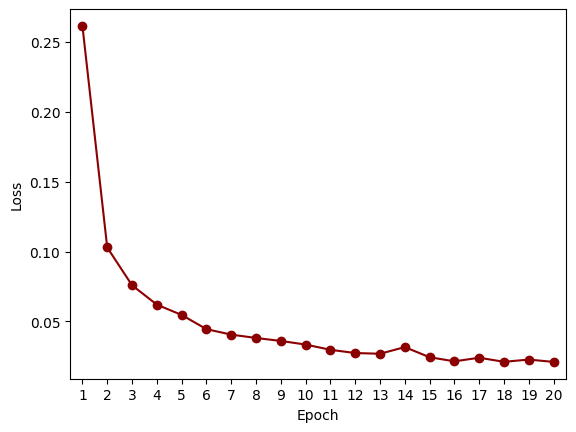

In [69]:
# plot training and validation losses as a function of epoch
# data is in 3 lists, each with 20 elements

# figure out the maximum loss from both lists
#all_losses = train_losses + val_losses # get all losses in one list
#max_loss = max(all_losses) # find the max value
# upper limit on the y axis
#upper_y = max_loss * 1.1

plt.figure() # new figure

# plot the training and validation losses
plt.plot(ep, train_losses, '-o', c='darkred', label="Training Loss");
#plt.plot(ep, val_losses, '-o', c='green', label="Validation Loss");

# format axes so the plot is neater
plt.xlim(0.5, 20.5)
plt.xticks(range(1,21)) # ticks at each epoch (1-20)
#plt.ylim(0, upper_y)

# add labels and a legend
plt.xlabel("Epoch");
plt.ylabel("Loss");
#plt.legend();

plt.show() # display figure

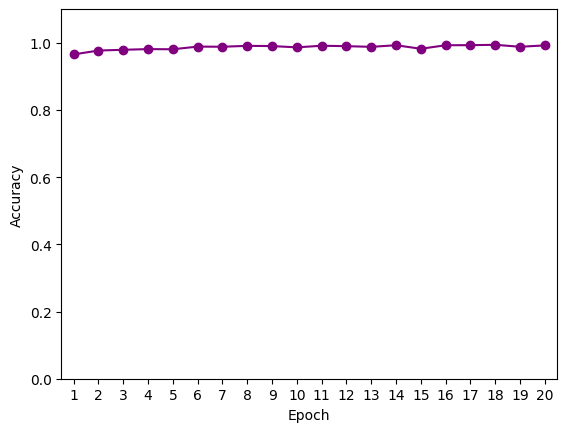

In [333]:
# plot accuracy as a function of epoch
# data is in 2 lists, each with 20 elements

plt.figure() # new figure

# plot the accuracy
plt.plot(ep, accs, '-o', c='purple');

# format axes
plt.xlim(0.5, 20.5)
plt.xticks(range(1,21)) # ticks at each epoch (1-20)
plt.ylim(0, 1.1) # change lower limit for better resolution

# add labels and a legend
plt.xlabel("Epoch");
plt.ylabel("Accuracy");

plt.show() # display figure

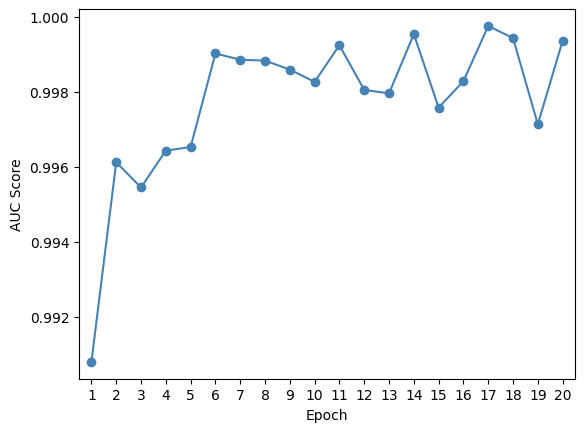

In [336]:
# plot auc score as a function of epoch

plt.figure() # new figure

# plot the auc score
plt.plot(ep, roc_aucs, '-o', c='steelblue');

# format axes so the plot is neater
plt.xlim(0.5, 20.5)
plt.xticks(range(1,21)) # ticks at each epoch (1-20)
#plt.ylim(0.5, 1) # uncomment to see full range (lower resolution)

# add labels and a legend
plt.xlabel("Epoch");
plt.ylabel("AUC Score");

plt.show() # display figure

Evaluate Performance Using Testing Data

### Classification of Test Data Using Model

At the end of the diagnostic and model tuning loop, the model parameters have been optimised. The final test of the model is to check its predictions for completely unknown data. The test data has not been used to train or tune the model, so it has not yet been "seen" by the network.

In [123]:
# for each set of training data
# i.e. for each model 0-8 / 1-9
# we want to evaluate it using the same set of testing data
# and measure some evaluation metrics

# 1. test loss
# 2. accuracy
# 3. roc-auc score
# 4. f1 score
# 5. confusion matrix ?
# 6. classification report ?

# set up empty lists to contain metric values for each model

test_losses_A = []
accuracy_A = []
auc_scores_A = []
f1_scores_A = []

In [124]:
# loop over all 9 training sets
for i in range(9): # 0-8

    # call the model we will use
    # this model has been trained using training set i
    model = models_A[i]
    
    # set model to evaluation mode
    model.eval()

    # run through test data once per model
    # compare model predictions to true labels

    # define total test loss
    total_loss = 0
    # total number of correct predictions
    total_correct = 0

    # define empty lists for computing roc_auc_score and f1_score
    all_probs = [] # probabilities
    all_preds = [] # predicted labels
    all_labels = [] # true labels

    # reset all of these for each new model

    # don't need to calculate gradients
    # so we can run this more efficiently
    with torch.no_grad():

        # loop through batches of the test data
        for X_batch, y_batch in test_loader_A:
            # for each batch of test data
            # push to the gpu if available
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # predict y values for test data
            # we are not using the loss function, so we need a sigmoid

            # forward pass on validation data
            y_logits = model(X_batch)
            # pass logits from model through sigmoid
            y_probs = torch.sigmoid(y_logits)
            # this is now a value between 0 and 1
            # round to the nearest integer to get the label (0 or 1)
            y_preds = torch.round(y_probs)

            # calculate losses on testing data
            # and add to total loss for this model    
            y_loss = loss_fn(y_logits, y_batch)
            total_loss += y_loss.item()*len(X_batch)

            # calculate accuracy of predictions
            # add this to total number of correct predictions
            correct = torch.eq(y_batch, y_preds).sum().item()
            total_correct += correct

            # save probabilities and labels for evaluation metrics
            # keep variables from each batch
            # sklearn cannot access gpu - move to the cpu first
            all_probs.append(y_probs.cpu())
            all_preds.append(y_preds.cpu())
            all_labels.append(y_batch.cpu())

        # looped through all batches of the test data

    # end of testing loop

    # calculate evaluation metrics for model i

    # calculate average test loss
    # divide by number of samples
    test_loss = (total_loss / len(test_set_A))

    # calculate accuracy
    # fraction of predictions that are correct
    test_acc = (total_correct / len(test_set_A))
    
    # for roc_auc and f1 calculations

    # concatenate lists of tensors into single tensors
    # then convert to numpy arrays
    all_y_probs = torch.cat(all_probs).numpy()
    all_y_preds = torch.cat(all_preds).numpy()
    all_y_labels = torch.cat(all_labels).numpy()

    # calculate roc_auc
    y_auc = metrics.roc_auc_score(all_y_labels, all_y_probs)

    # calculate F1 score
    y_f1 = metrics.f1_score(all_y_labels, all_y_preds)

    # add each metric to list for storage

    # average test loss
    test_losses_A.append(test_loss)

    # accuracy
    accuracy_A.append(test_acc)

    # roc_auc
    auc_scores_A.append(y_auc)

    # f1 scores  
    f1_scores_A.append(y_f1)

# end of for loop over i
# all models have now been tested

### Plot Evaluation Metrics by Amount of Training Data

plot metrics:

test_losses_A = []

accuracy_A = []

auc_scores_A = []

f1_scores_A = []

as a function of amount of training data

td_size = []

In [ ]:
print(len(test_losses_A))
print(len(accuracy_A))
print(len(auc_scores_A))
print(len(f1_scores_A))
print(len(td_size))

9
9
9
9
9


#### __Test Loss__

Calculated by the loss function.

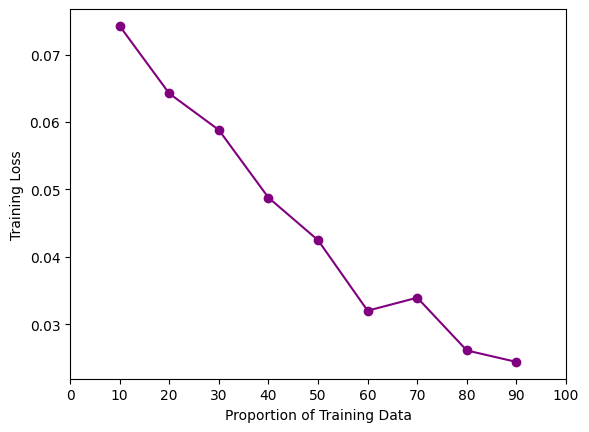

In [130]:
# plot test_losses_A against td_size
# 9 data points

# create array for positions of xticks
tens = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

plt.figure() # new figure

# plot the accuracy
plt.plot(td_size, test_losses_A, '-o', c='purple');

# format axes
plt.xlim(0, 100) # values go from 10 to 90
plt.xticks(tens) # ticks at each multiple of 10

# add axis labels
plt.xlabel("Proportion of Training Data");
plt.ylabel("Training Loss");

plt.show() # display figure

#### __Test Accuracy__

Fraction of predictions that match the true value.

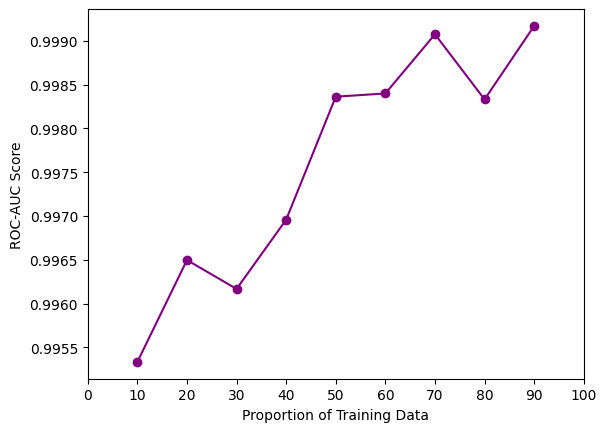

In [ ]:
# plot accuracy_A against td_size
# 9 data points

plt.figure() # new figure

# plot the accuracy
plt.plot(td_size, accuracy_A, '-o', c='purple');

# format axes
plt.xlim(0, 100) # values go from 10 to 90
plt.xticks(tens) # ticks at each multiple of 10

# add axis labels
plt.xlabel("Proportion of Training Data");
plt.ylabel("Accuracy");

plt.show() # display figure

#### __ROC-AUC Score__

Description of AUC Score

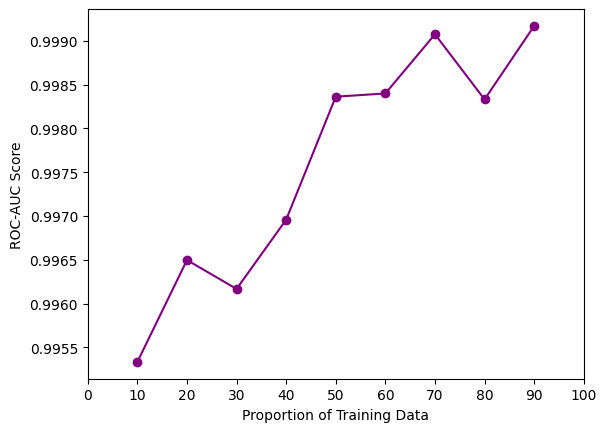

In [131]:
# plot auc_scores_A against td_size
# 9 data points

plt.figure() # new figure

# plot the accuracy
plt.plot(td_size, auc_scores_A, '-o', c='purple');

# format axes
plt.xlim(0, 100) # values go from 10 to 90
plt.xticks(tens) # ticks at each multiple of 10

# add axis labels
plt.xlabel("Proportion of Training Data");
plt.ylabel("ROC-AUC Score");

plt.show() # display figure

#### __F1 Score__

Description of F1 score.

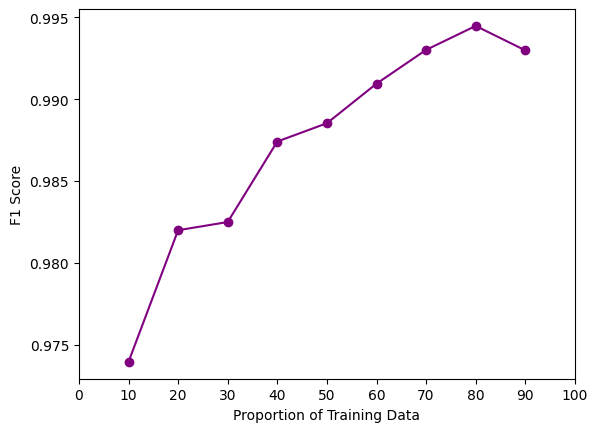

In [132]:
# plot f1_scores_A against td_size
# 9 data points

plt.figure() # new figure

# plot the accuracy
plt.plot(td_size, f1_scores_A, '-o', c='purple');

# format axes
plt.xlim(0, 100) # values go from 10 to 90
plt.xticks(tens) # ticks at each multiple of 10

# add axis labels
plt.xlabel("Proportion of Training Data");
plt.ylabel("F1 Score");

plt.show() # display figure

__Confusion Matrix__

Description of confusion matrix

Confusion Matrix:


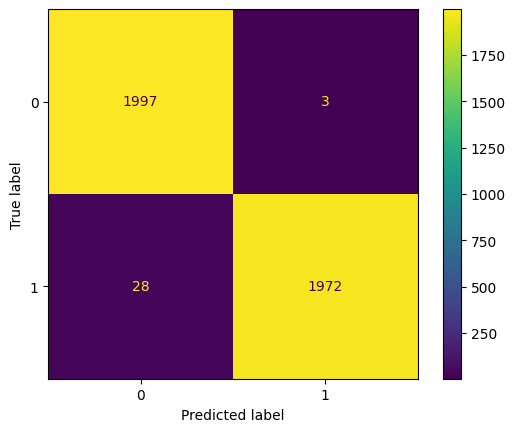

In [342]:
# compute the confusion matrix
con_mat = metrics.confusion_matrix(all_y_labels, all_y_preds)

# display the confusion matrix
print("Confusion Matrix:")
cm_vis = metrics.ConfusionMatrixDisplay(con_mat)
cm_vis.plot();

### Discussion of Test Results

* Average Loss:
* Test Accuracy:
* ROC-AUC Score:
* Precision and Recall:
* F1 Score:
* Confusion Matrix:
* Classification Report:

## 
> ## Resources

### Sources Used for Q3 Notebook

* links here